In [1]:
# !pip install pyparsing==2.4.6
# !pip install tensorflow

In [2]:
import sys
sys.path.append("../utils/") 
from utilities import performance_metrics
import time

from src.core import Term, Atom
from src.ilp import Language_Frame, Program_Template, Rule_Template
from src.dilp import DILP
import tensorflow as tf
import numpy as np
from src.utils import process_file, process_dir, output_rules, test_rule, create_table
from src.generate_template import create_templates
import duckdb

2024-04-02 21:51:31.202045: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 21:51:31.208029: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 21:51:31.271223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 21:51:32.372414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# arity 1
term_x_0 = Term(True, 'X_0')

In [4]:
con = duckdb.connect(':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

## Fraud

In [5]:
%%time 
input_dir = '../examples/fraud'
target, p_e, constants, B, P, N = process_dir(input_dir)
language_frame = Language_Frame(target, p_e, constants)

# p_a, rules = create_templates(p_e, target, term_x_0)
p_a, rules = create_templates(p_e[0:3], target, term_x_0)

578
end of facts processing
200
end of positive examples processing
200
end negative examples processing
data is in order
CPU times: user 117 ms, sys: 8.13 ms, total: 125 ms
Wall time: 126 ms


In [6]:
p_e

[type_PAYMENT(X_0),
 type_CASH_OUT(X_0),
 type_DEBIT(X_0),
 type_CASH_IN(X_0),
 external_dest(X_0),
 type_TRANSFER(X_0)]

In [7]:
p_a, target

([pred1(X_0)], isFraud(X_0))

In [8]:
# p_a = [Atom([term_x_0], 'pred')]
# target_rule = (Rule_Template(v=0, allow_intensional=True), None)
# p_a_rule_1 = (Rule_Template(v=0, allow_intensional=False), None)


# rules = {p_a[0]: p_a_rule_1, target: target_rule} 

In [9]:
program_template = Program_Template(p_a, rules, T=3)
print("DILP initialisation")
dilp = DILP(language_frame, B, P, N, program_template,  allow_target_recursion=True)
# dilp = DILP(langage_frame, B, P, N, program_template)
dilp.show_definition()
print("DILP Train")

DILP initialisation
----------------------------
isFraud(X_0)
isFraud(X_0) -> external_dest(X_0),pred1(X_0)
None
----------------------------
----------------------------
pred1(X_0)
pred1(X_0) -> type_TRANSFER(X_0),type_TRANSFER(X_0)
None
----------------------------
DILP Train


In [10]:
start_time = time.time()
dilp.train()
finish_time = time.time()

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 1.1977962255477905
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(50) Expected: 0 0.118
isFraud(67) Expected: 0 0.028
isFraud(169) Expected: 1 0.026
isFraud(93) Expected: 0 0.028
isFraud(99) Expected: 0 0.061
isFraud(64) Expected: 0 0.004
isFraud(134) Expected: 1 0.061
isFraud(29) Expected: 0 0.219
isFraud(18) Expected: 0 0.118
isFraud(75) Expected: 0 0.118
isFraud(76) Expected: 0 0.118
isFraud(179) Expected: 1 0.219
isFraud(174) Expected: 1 0.061
isFraud(35) Expected: 0 0.004
isFraud(167) Expected: 1 0.219
isFraud(56) Expected: 0 0.118
isFraud(111) Expected: 1 0.061
isFraud(136) Expected: 1 0.219
isFraud(124) Expected: 1 0.219
isFraud(34

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 30 loss is 0.6061937808990479
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.163
isFraud(153) Expected: 1 0.373
isFraud(146) Expected: 1 0.937
isFraud(57) Expected: 0 0.303
isFraud(80) Expected: 0 0.498
isFraud(101) Expected: 1 0.373
isFraud(155) Expected: 1 0.373
isFraud(82) Expected: 0 0.373
isFraud(32) Expected: 0 0.498
isFraud(74) Expected: 0 0.498
isFraud(73) Expected: 0 0.498
isFraud(137) Expected: 1 0.937
isFraud(110) Expected: 1 0.937
isFraud(88) Expected: 0 0.373
isFraud(14) Expected: 0 0.303
isFraud(39) Expected: 0 0.498
isFraud(27) Expected: 0 0.303
isFraud(123) Expected: 1 0.373
isFraud(45) Expected: 0 0.440
isFraud(111) Expected: 1 0.937
isFraud(182) Expected: 1 0.373
isFraud(113) Expected: 1 0.373
isFraud(168) Expected: 1 0.373
isFra

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 31 loss is 0.5888164043426514
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 32 loss is 0.5719057321548462
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 33 loss is 0.5555107593536377
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 37 loss is 0.49591174721717834
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 38 loss is 0.4826623499393463
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 39 loss is 0.47011199593544006
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 43 loss is 0.426925927400589
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 44 loss is 0.41782745718955994
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 45 loss is 0.4093634784221649
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.267
isFraud(153) Expected: 1 0.677
isFraud(146) 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 49 loss is 0.38116219639778137
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 50 loss is 0.3753284513950348
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.309
isFraud(153) Expected: 1 0.743
isFraud(146) Expected: 1 0.946
isFraud(57) Expected: 0 0.181
isFraud(80) Expected: 0 0.282
isFraud(101) Expected: 1 0.743
isFraud(155) Expected: 1 0.743
isFraud(82) Expected: 0 0.743
isFraud(32) Expected: 0 0.282
isFraud(74) Expected: 0 0.282
isFraud(73) Expected: 0 0.282
isFraud(137) Expected: 1 0.946
isFraud(110) Expected: 1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 55 loss is 0.35141634941101074
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.347
isFraud(153) Expected: 1 0.783
isFraud(146) Expected: 1 0.953
isFraud(57) Expected: 0 0.151
isFraud(80) Expected: 0 0.236
isFraud(101) Expected: 1 0.783
isFraud(155) Expected: 1 0.783
isFraud(82) Expected: 0 0.783
isFraud(32) Expected: 0 0.236
isFraud(74) Expected: 0 0.236
isFraud(73) Expected: 0 0.236
isFraud(137) Expected: 1 0.953
isFraud(110) Expected: 1 0.953
isFraud(88) Expected: 0 0.783
isFraud(14) Expected: 0 0.151
isFraud(39) Expected: 0 0.236
isFraud(27) Expected: 0 0.151
isFraud(123) Expected: 1 0.783
isFraud(45) Expected: 0 0.377
isFraud(111) Expected: 1 0.953
isFraud(182) Expected: 1 0.783
isFraud(113) Expected: 1 0.783
isFraud(168) Expected: 1 0.783
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 56 loss is 0.3474273383617401
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 57 loss is 0.3436304032802582
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 58 loss is 0.34000164270401
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 62 loss is 0.3268100321292877
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 63 loss is 0.32378140091896057
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 64 loss is 0.3208450376987457
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |███████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 68 loss is 0.3099561631679535
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 69 loss is 0.30744054913520813
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 70 loss is 0.30500656366348267
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.391
isFraud(153) Expected: 1 0.806
isFraud(146

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 74 loss is 0.29608529806137085
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 75 loss is 0.29405781626701355
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.387
isFraud(153) Expected: 1 0.804
isFraud(146) Expected: 1 0.970
isFraud(57) Expected: 0 0.062
isFraud(80) Expected: 0 0.099
isFraud(101) Expected: 1 0.804
isFraud(155) Expected: 1 0.804
isFraud(82) Expected: 0 0.804
isFraud(32) Expected: 0 0.099
isFraud(74) Expected: 0 0.099
isFraud(73) Expected: 0 0.099
isFraud(137) Expected: 1 0.970
isFraud(110) Expected: 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 80 loss is 0.2851029336452484
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.381
isFraud(153) Expected: 1 0.803
isFraud(146) Expected: 1 0.973
isFraud(57) Expected: 0 0.048
isFraud(80) Expected: 0 0.076
isFraud(101) Expected: 1 0.803
isFraud(155) Expected: 1 0.803
isFraud(82) Expected: 0 0.803
isFraud(32) Expected: 0 0.076
isFraud(74) Expected: 0 0.076
isFraud(73) Expected: 0 0.076
isFraud(137) Expected: 1 0.973
isFraud(110) Expected: 1 0.973
isFraud(88) Expected: 0 0.803
isFraud(14) Expected: 0 0.048
isFraud(39) Expected: 0 0.076
isFraud(27) Expected: 0 0.048
isFraud(123) Expected: 1 0.803
isFraud(45) Expected: 0 0.179
isFraud(111) Expected: 1 0.973
isFraud(182) Expected: 1 0.803
isFraud(113) Expected: 1 0.803
isFraud(168) Expected: 1 0.803
isFra

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 81 loss is 0.28353917598724365
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 82 loss is 0.2820470929145813
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 83 loss is 0.28062450885772705
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 87 loss is 0.2755831778049469
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 88 loss is 0.27447301149368286
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 89 loss is 0.27341797947883606
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 93 loss is 0.2697032690048218
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 94 loss is 0.26888978481292725
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 95 loss is 0.2681182324886322
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.372
isFraud(153) Expected: 1 0.802
isFraud(146)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 99 loss is 0.26541322469711304
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 100 loss is 0.2648233473300934
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.373
isFraud(153) Expected: 1 0.802
isFraud(146) Expected: 1 0.977
isFraud(57) Expected: 0 0.016
isFraud(80) Expected: 0 0.025
isFraud(101) Expected: 1 0.802
isFraud(155) Expected: 1 0.802
isFraud(82) Expected: 0 0.802
isFraud(32) Expected: 0 0.025
isFraud(74) Expected: 0 0.025
isFraud(73) Expected: 0 0.025
isFraud(137) Expected: 1 0.977
isFraud(110) Expected: 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 105 loss is 0.2623121440410614
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.373
isFraud(153) Expected: 1 0.802
isFraud(146) Expected: 1 0.977
isFraud(57) Expected: 0 0.012
isFraud(80) Expected: 0 0.019
isFraud(101) Expected: 1 0.802
isFraud(155) Expected: 1 0.802
isFraud(82) Expected: 0 0.802
isFraud(32) Expected: 0 0.019
isFraud(74) Expected: 0 0.019
isFraud(73) Expected: 0 0.019
isFraud(137) Expected: 1 0.977
isFraud(110) Expected: 1 0.977
isFraud(88) Expected: 0 0.802
isFraud(14) Expected: 0 0.012
isFraud(39) Expected: 0 0.019
isFraud(27) Expected: 0 0.012
isFraud(123) Expected: 1 0.802
isFraud(45) Expected: 0 0.053
isFraud(111) Expected: 1 0.977
isFraud(182) Expected: 1 0.802
isFraud(113) Expected: 1 0.802
isFraud(168) Expected: 1 0.802
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 106 loss is 0.2618875503540039
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 107 loss is 0.261485755443573
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 108 loss is 0.26110556721687317
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 112 loss is 0.25977927446365356
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 113 loss is 0.2594930827617645
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 114 loss is 0.2592395842075348
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 118 loss is 0.26004835963249207
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 119 loss is 0.2590795159339905
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 120 loss is 0.2584162652492523
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.816
isFraud(1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 124 loss is 0.25754421949386597
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 125 loss is 0.25741490721702576
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.366
isFraud(153) Expected: 1 0.796
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.004
isFraud(80) Expected: 0 0.007
isFraud(101) Expected: 1 0.796
isFraud(155) Expected: 1 0.796
isFraud(82) Expected: 0 0.796
isFraud(32) Expected: 0 0.007
isFraud(74) Expected: 0 0.007
isFraud(73) Expected: 0 0.007
isFraud(137) Expected: 1 0.976
isFraud(110) Expected

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 130 loss is 0.25753143429756165
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.399
isFraud(153) Expected: 1 0.827
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.004
isFraud(80) Expected: 0 0.006
isFraud(101) Expected: 1 0.827
isFraud(155) Expected: 1 0.827
isFraud(82) Expected: 0 0.827
isFraud(32) Expected: 0 0.006
isFraud(74) Expected: 0 0.006
isFraud(73) Expected: 0 0.006
isFraud(137) Expected: 1 0.978
isFraud(110) Expected: 1 0.978
isFraud(88) Expected: 0 0.827
isFraud(14) Expected: 0 0.004
isFraud(39) Expected: 0 0.006
isFraud(27) Expected: 0 0.004
isFraud(123) Expected: 1 0.827
isFraud(45) Expected: 0 0.017
isFraud(111) Expected: 1 0.978
isFraud(182) Expected: 1 0.827
isFraud(113) Expected: 1 0.827
isFraud(168) Expected: 1 0.827
isF

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 131 loss is 0.2579347491264343
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 132 loss is 0.2580609917640686
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 133 loss is 0.2577912509441376
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 137 loss is 0.2564754784107208
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 138 loss is 0.2563548982143402
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 139 loss is 0.2562825083732605
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 143 loss is 0.2563977539539337
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 144 loss is 0.2565149664878845
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 145 loss is 0.25662311911582947
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.347
isFraud(153) Expected: 1 0.773
isFraud(1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 149 loss is 0.2560931444168091
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 150 loss is 0.2559341788291931
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.395
isFraud(153) Expected: 1 0.823
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.002
isFraud(80) Expected: 0 0.003
isFraud(101) Expected: 1 0.823
isFraud(155) Expected: 1 0.823
isFraud(82) Expected: 0 0.823
isFraud(32) Expected: 0 0.003
isFraud(74) Expected: 0 0.003
isFraud(73) Expected: 0 0.003
isFraud(137) Expected: 1 0.978
isFraud(110) Expected: 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 155 loss is 0.2557504177093506
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.354
isFraud(153) Expected: 1 0.781
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.001
isFraud(80) Expected: 0 0.002
isFraud(101) Expected: 1 0.781
isFraud(155) Expected: 1 0.781
isFraud(82) Expected: 0 0.781
isFraud(32) Expected: 0 0.002
isFraud(74) Expected: 0 0.002
isFraud(73) Expected: 0 0.002
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 1 0.976
isFraud(88) Expected: 0 0.781
isFraud(14) Expected: 0 0.001
isFraud(39) Expected: 0 0.002
isFraud(27) Expected: 0 0.001
isFraud(123) Expected: 1 0.781
isFraud(45) Expected: 0 0.006
isFraud(111) Expected: 1 0.976
isFraud(182) Expected: 1 0.781
isFraud(113) Expected: 1 0.781
isFraud(168) Expected: 1 0.781
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 156 loss is 0.25578317046165466
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 157 loss is 0.25584790110588074
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 158 loss is 0.2558720111846924
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |███████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 162 loss is 0.2556784749031067
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 163 loss is 0.25560835003852844
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 164 loss is 0.255523145198822
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 168 loss is 0.25543129444122314
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 169 loss is 0.25545981526374817
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 170 loss is 0.2554682493209839
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 174 loss is 0.25545409321784973
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 175 loss is 0.25543153285980225
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.352
isFraud(153) Expected: 1 0.778
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.001
isFraud(80) Expected: 0 0.001
isFraud(101) Expected: 1 0.778
isFraud(155) Expected: 1 0.778
isFraud(82) Expected: 0 0.778
isFraud(32) Expected: 0 0.001
isFraud(74) Expected: 0 0.001
isFraud(73) Expected: 0 0.001
isFraud(137) Expected: 1 0.976
isFraud(110) Expected

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 180 loss is 0.2552609145641327
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.396
isFraud(153) Expected: 1 0.825
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.001
isFraud(101) Expected: 1 0.825
isFraud(155) Expected: 1 0.825
isFraud(82) Expected: 0 0.825
isFraud(32) Expected: 0 0.001
isFraud(74) Expected: 0 0.001
isFraud(73) Expected: 0 0.001
isFraud(137) Expected: 1 0.978
isFraud(110) Expected: 1 0.978
isFraud(88) Expected: 0 0.825
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.001
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.825
isFraud(45) Expected: 0 0.002
isFraud(111) Expected: 1 0.978
isFraud(182) Expected: 1 0.825
isFraud(113) Expected: 1 0.825
isFraud(168) Expected: 1 0.825
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 181 loss is 0.25527071952819824
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 182 loss is 0.2552616000175476
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 183 loss is 0.25528401136398315
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |███████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 187 loss is 0.2552858889102936
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 188 loss is 0.2552531063556671
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 189 loss is 0.2552478313446045
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 193 loss is 0.25517940521240234
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 194 loss is 0.255160391330719
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 195 loss is 0.2551739811897278
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(14

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 199 loss is 0.25518327951431274
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 200 loss is 0.2551645040512085
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.978
isFraud(110) Expected:

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 205 loss is 0.25513163208961487
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 1 0.976
isFraud(88) Expected: 0 0.779
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.779
isFraud(45) Expected: 0 0.001
isFraud(111) Expected: 1 0.976
isFraud(182) Expected: 1 0.779
isFraud(113) Expected: 1 0.779
isFraud(168) Expected: 1 0.779
isF

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 206 loss is 0.2551101744174957
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 207 loss is 0.2551201283931732
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 208 loss is 0.25510403513908386
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 212 loss is 0.25510650873184204
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 213 loss is 0.25512006878852844
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 214 loss is 0.2551025152206421
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |███████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 218 loss is 0.2550821304321289
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 219 loss is 0.25509196519851685
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 220 loss is 0.2550745904445648
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 224 loss is 0.25507214665412903
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 225 loss is 0.2550865411758423
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected:

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 230 loss is 0.2550632953643799
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.978
isFraud(110) Expected: 1 0.978
isFraud(88) Expected: 0 0.826
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.826
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.978
isFraud(182) Expected: 1 0.826
isFraud(113) Expected: 1 0.826
isFraud(168) Expected: 1 0.826
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 231 loss is 0.2550745904445648
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 232 loss is 0.25505778193473816
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 233 loss is 0.255069762468338
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 237 loss is 0.255066841840744
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 238 loss is 0.2550526559352875
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 239 loss is 0.2550666332244873
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 243 loss is 0.2550625503063202
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 244 loss is 0.2550467550754547
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 245 loss is 0.25505945086479187
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 249 loss is 0.2550557851791382
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 250 loss is 0.25504136085510254
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.978
isFraud(110) Expected:

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 255 loss is 0.2550538182258606
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 1 0.976
isFraud(88) Expected: 0 0.779
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.779
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.976
isFraud(182) Expected: 1 0.779
isFraud(113) Expected: 1 0.779
isFraud(168) Expected: 1 0.779
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 256 loss is 0.2550388276576996
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 257 loss is 0.2550521790981293
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 258 loss is 0.2550370991230011
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 262 loss is 0.25503456592559814
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 263 loss is 0.25504839420318604
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 264 loss is 0.25503402948379517
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 268 loss is 0.2550329566001892
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 269 loss is 0.25504669547080994
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 270 loss is 0.2550320029258728
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 274 loss is 0.2550300657749176
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 275 loss is 0.2550438344478607
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 280 loss is 0.25502854585647583
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.978
isFraud(110) Expected: 1 0.978
isFraud(88) Expected: 0 0.826
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.826
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.978
isFraud(182) Expected: 1 0.826
isFraud(113) Expected: 1 0.826
isFraud(168) Expected: 1 0.826
isF

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 281 loss is 0.2550423741340637
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 282 loss is 0.25502797961235046
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 283 loss is 0.2550417184829712
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 287 loss is 0.2550402879714966
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 288 loss is 0.2550259828567505
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 289 loss is 0.2550397515296936
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 293 loss is 0.2550388276576996
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 294 loss is 0.2550245523452759
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 295 loss is 0.2550383508205414
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(14

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 299 loss is 0.2550372779369354
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 300 loss is 0.2550230324268341
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.978
isFraud(110) Expected: 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 305 loss is 0.25503575801849365
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 1 0.976
isFraud(88) Expected: 0 0.779
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.779
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.976
isFraud(182) Expected: 1 0.779
isFraud(113) Expected: 1 0.779
isFraud(168) Expected: 1 0.779
isF

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 306 loss is 0.2550216615200043
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 307 loss is 0.25503531098365784
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 308 loss is 0.25502121448516846
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |███████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 312 loss is 0.25502029061317444
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 313 loss is 0.25503385066986084
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 314 loss is 0.25501978397369385
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 318 loss is 0.25501883029937744
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 319 loss is 0.25503236055374146
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 320 loss is 0.255018413066864
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 324 loss is 0.25501754879951477
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 325 loss is 0.25503093004226685
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 330 loss is 0.255016028881073
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.397
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.978
isFraud(110) Expected: 1 0.978
isFraud(88) Expected: 0 0.826
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.826
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.978
isFraud(182) Expected: 1 0.826
isFraud(113) Expected: 1 0.826
isFraud(168) Expected: 1 0.826
isFra

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 331 loss is 0.2550293803215027
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 332 loss is 0.2550155818462372
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 333 loss is 0.2550288438796997
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 337 loss is 0.2550278604030609
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 338 loss is 0.2550141513347626
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 339 loss is 0.25502726435661316
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 343 loss is 0.2550261318683624
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 344 loss is 0.25501254200935364
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 345 loss is 0.25502559542655945
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.353
isFraud(153) Expected: 1 0.779
isFraud(

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 349 loss is 0.2550244629383087
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 350 loss is 0.2550109922885895
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.396
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.978
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.978
isFraud(110) Expected: 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 355 loss is 0.2550226151943207
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.354
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 1 0.976
isFraud(88) Expected: 0 0.779
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.779
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.976
isFraud(182) Expected: 1 0.779
isFraud(113) Expected: 1 0.779
isFraud(168) Expected: 1 0.779
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 356 loss is 0.255009263753891
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 357 loss is 0.25502195954322815
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 358 loss is 0.25500863790512085
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 362 loss is 0.25500744581222534
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 363 loss is 0.25502002239227295
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 364 loss is 0.2550068199634552
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |███████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 368 loss is 0.25500553846359253
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 369 loss is 0.2550179362297058
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 370 loss is 0.2550048530101776
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.396
isFraud(153) Expected: 1 0.826
isFraud(1

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 374 loss is 0.2550034523010254
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 375 loss is 0.25501567125320435
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.354
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 1 0.976
isFraud(88) 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 380 loss is 0.2550013065338135
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.396
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.977
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.977
isFraud(110) Expected: 1 0.977
isFraud(88) Expected: 0 0.826
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.826
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.977
isFraud(182) Expected: 1 0.826
isFraud(113) Expected: 1 0.826
isFraud(168) Expected: 1 0.826
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 381 loss is 0.25501328706741333
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 382 loss is 0.2550005316734314
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 383 loss is 0.2550124228000641
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 387 loss is 0.2550106942653656
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 388 loss is 0.25499817728996277
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 389 loss is 0.25500982999801636
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |███████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 393 loss is 0.2550080120563507
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 394 loss is 0.2549956142902374
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 395 loss is 0.2550070285797119
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.355
isFraud(153) Expected: 1 0.779
isFraud(14

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 399 loss is 0.2550051212310791
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 400 loss is 0.25499293208122253
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.395
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.977
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.977
isFraud(110) Expected:

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 405 loss is 0.2550020217895508
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.355
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 1 0.976
isFraud(88) Expected: 0 0.779
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.779
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.976
isFraud(182) Expected: 1 0.779
isFraud(113) Expected: 1 0.779
isFraud(168) Expected: 1 0.779
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 406 loss is 0.2549900412559509
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 407 loss is 0.2550009787082672
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 408 loss is 0.2549890875816345
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 412 loss is 0.25498709082603455
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 413 loss is 0.25499770045280457
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 414 loss is 0.254986047744751
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 418 loss is 0.25498393177986145
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 419 loss is 0.2549942433834076
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 420 loss is 0.2549828588962555
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.395
isFraud(153) Expected: 1 0.826
isFraud(1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 424 loss is 0.2549806833267212
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 425 loss is 0.25499069690704346
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.356
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected:

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 430 loss is 0.2549772560596466
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.394
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.977
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.977
isFraud(110) Expected: 1 0.977
isFraud(88) Expected: 0 0.826
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.826
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.977
isFraud(182) Expected: 1 0.826
isFraud(113) Expected: 1 0.826
isFraud(168) Expected: 1 0.826
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 431 loss is 0.2549869418144226
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 432 loss is 0.2549760937690735
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 433 loss is 0.2549857199192047
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |█████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 437 loss is 0.25498318672180176
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 438 loss is 0.2549726366996765
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 439 loss is 0.2549819052219391
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 443 loss is 0.25497928261756897
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 444 loss is 0.25496894121170044
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 445 loss is 0.2549779415130615
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.357
isFraud(153) Expected: 1 0.779
isFraud(

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 449 loss is 0.2549753487110138
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 450 loss is 0.2549653947353363
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.393
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.977
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.977
isFraud(110) Expected: 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 455 loss is 0.25497135519981384
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.358
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected: 1 0.976
isFraud(88) Expected: 0 0.779
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.779
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.976
isFraud(182) Expected: 1 0.779
isFraud(113) Expected: 1 0.779
isFraud(168) Expected: 1 0.779
isF

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 456 loss is 0.25496169924736023
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 457 loss is 0.2549700140953064
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 458 loss is 0.25496044754981995
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |███████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 462 loss is 0.25495803356170654
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 463 loss is 0.25496605038642883
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 464 loss is 0.25495681166648865
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 468 loss is 0.25495445728302
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 469 loss is 0.25496208667755127
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 470 loss is 0.25495320558547974
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.392
isFraud(153) Expected: 1 0.826
isFraud(14

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 474 loss is 0.2549506425857544
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 475 loss is 0.2549583911895752
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.359
isFraud(153) Expected: 1 0.779
isFraud(146) Expected: 1 0.977
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.779
isFraud(155) Expected: 1 0.779
isFraud(82) Expected: 0 0.779
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.977
isFraud(110) Expected: 

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 480 loss is 0.2549455761909485
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.391
isFraud(153) Expected: 1 0.826
isFraud(146) Expected: 1 0.977
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.826
isFraud(155) Expected: 1 0.826
isFraud(82) Expected: 0 0.826
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.977
isFraud(110) Expected: 1 0.977
isFraud(88) Expected: 0 0.826
isFraud(14) Expected: 0 0.000
isFraud(39) Expected: 0 0.000
isFraud(27) Expected: 0 0.000
isFraud(123) Expected: 1 0.826
isFraud(45) Expected: 0 0.000
isFraud(111) Expected: 1 0.977
isFraud(182) Expected: 1 0.826
isFraud(113) Expected: 1 0.826
isFraud(168) Expected: 1 0.826
isFr

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 481 loss is 0.2549537420272827
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 482 loss is 0.2549443542957306
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 483 loss is 0.25495269894599915
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 487 loss is 0.2549474239349365
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 488 loss is 0.2549343407154083
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 489 loss is 0.25493672490119934
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |████████████████

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 493 loss is 0.2550453245639801
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 494 loss is 0.25505325198173523
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 495 loss is 0.2550623416900635
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.388
isFraud(153) Expected: 1 0.777
isFraud(1

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 499 loss is 0.25477856397628784
--------------------

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 500 loss is 0.2547483444213867
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(54) Expected: 0 0.370
isFraud(153) Expected: 1 0.822
isFraud(146) Expected: 1 0.976
isFraud(57) Expected: 0 0.000
isFraud(80) Expected: 0 0.000
isFraud(101) Expected: 1 0.822
isFraud(155) Expected: 1 0.822
isFraud(82) Expected: 0 0.822
isFraud(32) Expected: 0 0.000
isFraud(74) Expected: 0 0.000
isFraud(73) Expected: 0 0.000
isFraud(137) Expected: 1 0.976
isFraud(110) Expected:

In [11]:
print("execution time %d" % (finish_time - start_time))

execution time 166


In [12]:
clauses = dilp.show_definition()
sql_str=output_rules(clauses)

----------------------------
isFraud(X_0)
isFraud(X_0) -> pred1(X_0),pred1(X_0)
None
----------------------------
----------------------------
pred1(X_0)
pred1(X_0) -> type_TRANSFER(X_0),type_TRANSFER(X_0)
None
----------------------------
pred1 : type_TRANSFER type_TRANSFER
isFraud : pred1 pred1


In [13]:
sql_str

'select type_TRANSFER and type_TRANSFER as pred1,\n pred1 and pred1 as isFraud,\n'

In [14]:
target.predicate

'isFraud'

Accuracy: 0.730000
Precision TP/(TP+FP): 0.896552
Recall TP/(TP+FN): 0.520000
F1 Score: 0.658228
MCC Score: 0.506874


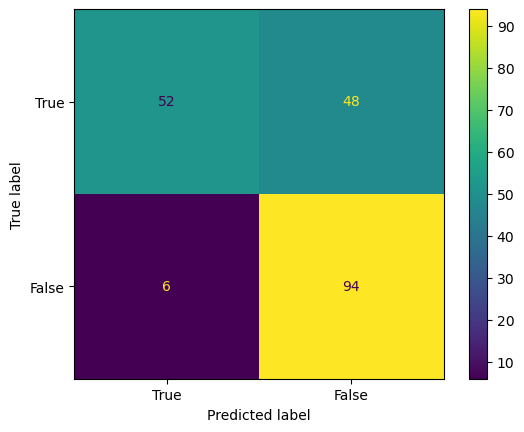

In [15]:
input_table = create_table(con, input_dir)
predicted_table = test_rule(con, sql_str, target_predicate=target.predicate)
performance_metrics(predicted_table[target.predicate],input_table[target.predicate], labels=[True,False])

# create all possible predicates

In [16]:
p_a, rules = create_templates(p_e, target, term_x_0)
program_template = Program_Template(p_a, rules, T=3)
print("DILP initialisation")
dilp = DILP(language_frame, B, P, N, program_template,  allow_target_recursion=True)
# dilp = DILP(langage_frame, B, P, N, program_template)
dilp.show_definition()
print("DILP Train")

DILP initialisation
----------------------------
isFraud(X_0)
isFraud(X_0) -> type_CASH_OUT(X_0),pred4(X_0)
None
----------------------------
----------------------------
pred1(X_0)
pred1(X_0) -> external_dest(X_0),isFraud(X_0)
None
----------------------------
----------------------------
pred2(X_0)
pred2(X_0) -> type_TRANSFER(X_0),pred4(X_0)
None
----------------------------
----------------------------
pred3(X_0)
pred3(X_0) -> type_CASH_IN(X_0),pred4(X_0)
None
----------------------------
----------------------------
pred4(X_0)
pred4(X_0) -> type_DEBIT(X_0),type_CASH_IN(X_0)
None
----------------------------
DILP Train


In [18]:
start_time = time.time()
dilp.train()
finish_time = time.time()

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 2.282918930053711
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
isFraud(50) Expected: 0 0.029
isFraud(67) Expected: 0 0.000
isFraud(169) Expected: 1 0.002
isFraud(93) Expected: 0 0.000
isFraud(99) Expected: 0 0.007
isFraud(64) Expected: 0 0.001
isFraud(134) Expected: 1 0.007
isFraud(29) Expected: 0 0.024
isFraud(18) Expected: 0 0.029
isFraud(75) Expected: 0 0.029
isFraud(76) Expected: 0 0.029
isFraud(179) Expected: 1 0.024
isFraud(174) Expected: 1 0.007
isFraud(35) Expected: 0 0.001
isFraud(167) Expected: 1 0.024
isFraud(56) Expected: 0 0.029
isFraud(111) Expected: 1 0.007
isFraud(136) Expected: 1 0.024
isFraud(124) Expected: 1 0.024
isFraud(34)

----------------------------
isFraud(X_0)
isFraud(X_0) -> pred4(X_0),pred4(X_0)
None
----------------------------
----------------------------
pred1(X_0)
pred1(X_0) -> external_dest(X_0),isFraud(X_0)
None
----------------------------
----------------------------
pred2(X_0)
pred2(X_0) -> type_TRANSFER(X_0),pred4(X_0)
None
----------------------------
----------------------------
pred3(X_0)
pred3(X_0) -> type_CASH_OUT(X_0),pred4(X_0)
None
----------------------------
----------------------------
pred4(X_0)
pred4(X_0) -> type_TRANSFER(X_0),type_TRANSFER(X_0)
None
----------------------------
pred4 : type_TRANSFER type_TRANSFER
pred3 : type_CASH_OUT pred4
pred2 : type_TRANSFER pred4
pred1 : external_dest isFraud
isFraud : pred4 pred4
previous table dropped
Accuracy: 0.730000
Precision TP/(TP+FP): 0.896552
Recall TP/(TP+FN): 0.520000
F1 Score: 0.658228
MCC Score: 0.506874


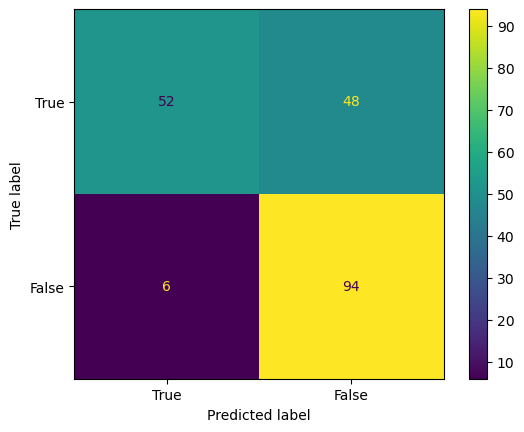

In [19]:
clauses = dilp.show_definition()
sql_str=output_rules(clauses)
input_table = create_table(con, input_dir)
predicted_table = test_rule(con, sql_str, target_predicate=target.predicate)
performance_metrics(predicted_table[target.predicate],input_table[target.predicate], labels=[True,False])